In [1]:
import numpy as np
import cv2
import os
from PIL import Image as IMG
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy

In [2]:
# cdir = os.getcwd()
# os.chdir('../ature')
# import utils.img_utils as iu
# os.chdir(cdir)

### This is the object where we store each detected flares and we filter the qualified ones later

In [3]:
class LightSrc():
    def __init__(self, center, IJs, diam, contour):
        self.center = center
        self.IJs = IJs
        self.diam = diam
        self.contour = contour
        self.flags = {}
        
### Find all light sources contours
def get_ligt_sources(thr):
    ret, labels = cv2.connectedComponents(thr)
    for l in range(1, ret):
        try:
            I, J = np.where(labels==l)
            c = np.zeros_like(labels, dtype=np.uint8)
            c[I, J] = 255

            image, c, hierarchy = cv2.findContours(c, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            
            # compute the center of the contour
            M = cv2.moments(c[0])
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            #Compute diameter
            c = c[0].squeeze()
            ixy = c[c[:,1].argsort()]
            x1, y1 = ixy[0]
            x2, y2 = ixy[-1]
            dst = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

            yield LightSrc(center=(cX, cY), IJs=(I, J), diam=round(dst,2), contour=c)
        except Exception as e:
            print('Failed:', e, end='\r')

### Generate flares for the each valid flares

In [4]:
def increase_brightness(img, value=100):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    h1 = math.floor(v.shape[0]/2)
    h2 = math.ceil(v.shape[0]/2)
    
    m1 = np.linspace(1, value, int(h1))
    m2 = np.linspace(1, value, int(h2))[::-1]
    value_row = np.append(m1, m2)[..., None]
    value_row = value_row.astype(np.uint8)

    lim = 255 - value_row
    v[v > lim] = 255
    c = (v <= lim).astype(np.uint8)
    v+=c*value_row
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# MAIN EXECUTION

In [6]:
Params = {}
Params['input_video'] = 'vid/CV.mp4'
Params['output_video'] = 'vid/result.mp4'
Params['write_fps'] = 30.0
Params['binarize_thr'] = 240
Params['conn_comp_diam_limit'] = (10, 500)
Params['light_src_limit'] = 5
Params['bright_increment'] = 150

cap = cv2.VideoCapture(Params['input_video'])
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(Params['output_video'], fourcc, Params['write_fps'], (width,height))
while(cap.isOpened()):
    ret, frame_orig = cap.read()
    if ret==True:
        frame = frame_orig.copy()
        imgray = frame[:,:,1]
        blur = cv2.GaussianBlur(imgray,(31,31),0)
        thr = blur.copy()
        t= Params['binarize_thr']
        thr[thr>t] = 255
        thr[thr<=t] = 0
        
        # Draw contour for all light sources
        added_light_src_count = 0
        for src in get_ligt_sources(thr):
            
            # Option to specify number of flares to generate
            if added_light_src_count >= Params['light_src_limit']:
                break
            
#             # Only pick selected size of light sources
            if src.diam < Params['conn_comp_diam_limit'][0] or src.diam > Params['conn_comp_diam_limit'][1]:
                continue
                
            # Only pick the contours where all RGB values are higher than a threshold
            rgb_max = frame[src.IJs].max(0).astype(float)
            if  (rgb_max >= [Params['binarize_thr']] * 3).sum() < 3:
                continue

#             cv2.drawContours(frame, [src.contour], -1, (0, 255, 0), 2)
#             cv2.circle(frame, src.center, 2, (255, 0, 0), -1)
            
            
            # Find the horigental span of each flare
            sorted_x = src.contour[src.contour[:,1].argsort()]
            u, v = sorted_x[0], sorted_x[-1]
#             frame[u[1], :, 1]=255
#             frame[v[1], :, 1]=255
            
            # Increase brightness with an offset from boundary
            flare_from, flare_to = u[1], v[1]
            frame[flare_from:flare_to, :, :] = increase_brightness(frame[flare_from:flare_to, :, :], Params['bright_increment'])
            added_light_src_count += 1
        
#         break
        out.write(frame)
#         cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

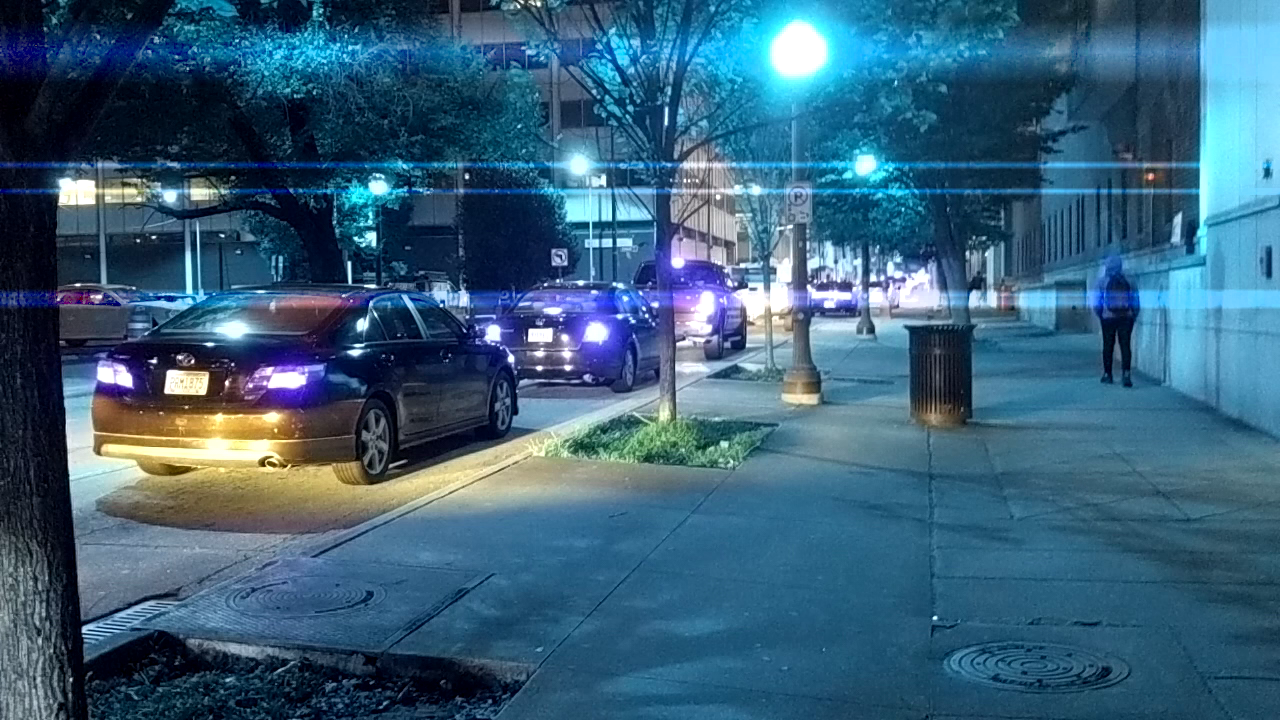

In [210]:
IMG.fromarray(frame)